# Libraries

In [1]:
import numpy as np
import pandas as pd
import os, sys, gc
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, mean_squared_error, mean_absolute_error, f1_score
from tqdm import tqdm

from multiprocessing import Pool, cpu_count
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet import Prophet

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

sys.path.append('/analysis/script/')
from wrmsse_evaluator import WRMSSEEvaluator

import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


# Load data

In [2]:
input_dir = '../input/'
def load_data():
    df_sale = pd.read_csv(input_dir + 'sales_train_validation.csv')
    df_calendar = pd.read_csv(input_dir + 'calendar.csv')
    df_price = pd.read_csv(input_dir + 'sell_prices.csv')
    df_eval = pd.read_csv(input_dir + 'sales_train_evaluation.csv')
    return df_sale, df_calendar, df_price, df_eval
df_sale, df_calendar, df_price, df_eval = load_data()

In [3]:
print(df_sale.shape)
df_sale.head()

(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [4]:
print(df_calendar.shape)
df_calendar.head()

(1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
print(df_price.shape)
df_price.head()

(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# evaluation data

In [6]:
print(df_eval.shape)
df_eval.head()

(30490, 1947)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [7]:
# # evaluator
# evaluator = WRMSSEEvaluator(df_eval.iloc[:, :-28], df_eval.iloc[:, -28:], df_calendar, df_price)

# def get_LBscore(preds_valid):
#     groups, scores = evaluator.score(preds_valid)
#     for i in range(len(groups)):
#         print(f"Score for group {groups[i]}: {round(scores[i], 5)}")
#     print('*'*50)
#     print(f"\nPublic LB Score: {round(score_public_lb, 5)}")
#     print('*'*50)

# Make timeseries

In [8]:
columns = df_sale.columns
date_columns = columns[columns.str.contains("d_")]
dates_s = [pd.to_datetime(df_calendar.loc[df_calendar['d'] == str_date,'date'].values[0]) for str_date in date_columns]

tmp = df_sale[date_columns].sum()
ignore_date = df_calendar[df_calendar['d'].isin(tmp[tmp < 10000].index.values)]['date'].values

df_ev_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': df_calendar[~df_calendar['event_name_1'].isna()]['date']})
df_ev_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': df_calendar[~df_calendar['event_name_2'].isna()]['date']})
df_ev_3 = pd.DataFrame({'holiday': 'snap_CA', 'ds': df_calendar[df_calendar['snap_CA'] == 1]['date']})
df_ev_4 = pd.DataFrame({'holiday': 'snap_TX', 'ds': df_calendar[df_calendar['snap_TX'] == 1]['date']})
df_ev_5 = pd.DataFrame({'holiday': 'snap_WI', 'ds': df_calendar[df_calendar['snap_WI'] == 1]['date']})
holidays = pd.concat((df_ev_1, df_ev_2, df_ev_3, df_ev_4, df_ev_5))

In [37]:
def CreateTimeSeries(df, id, start_date='2014-04-20'):
    item_series = df[df['id'] == id]
    columns = df.columns
    date_columns = columns[columns.str.contains("d_")]
    dates_s = [pd.to_datetime(df_calendar.loc[df_calendar['d'] == str_date,'date'].values[0]) for str_date in date_columns]
    dates = pd.DataFrame({'ds': dates_s}, index=range(len(dates_s)))
    dates['y'] = item_series[date_columns].values.transpose()
    # Remove chirstmas date
    #dates = dates[~dates['ds'].isin(ignore_date)]
    # Remove zero day
    #dates = dates[dates['y'] > 0]        
    idx = np.where(dates['ds'] == start_date)[0][0]
    dates = dates.iloc[idx:].reset_index(drop=True)
    return dates
    
prophet_params = {
        'uncertainty_samples': False,
        'holidays': holidays,
        'changepoint_prior_scale': 0.1,
        'seasonality_mode': 'additive' # multiplicative
}

def run_prophet(timeseries, params=prophet_params, add_country_holiday=True):
    # given holidays
    model = Prophet(**params)
        
    # country holidays
    if add_country_holiday:
        model.add_country_holidays(country_name='US')
    
    # fit and predict
    model.fit(timeseries)
    forecast = model.make_future_dataframe(periods=28, include_history=False)
    forecast = model.predict(forecast)
    return forecast['yhat'].values.transpose()

def run_statsmodel(timeseries, model='Holt'):
    predicted = np.zeros(28)
    if model == 'SimpleExpSmoothing':
        fitted = SimpleExpSmoothing(timeseries['y'].values).fit()
    elif model == 'Holt':
        fitted = Holt(timeseries['y'].values).fit()
    return fitted.forecast(28)

# Example

In [10]:
# example
id = 'HOBBIES_1_004_CA_1_validation'
dates = CreateTimeSeries(df_sale, id)
id = 'HOBBIES_1_004_CA_1_evaluation'
dates_eval = CreateTimeSeries(df_eval, id)

In [11]:
print(dates.shape)
dates.head()

(1913, 2)


,ds,y
0,2011-01-29,0
1,2011-01-30,0
2,2011-01-31,0
3,2011-02-01,0
4,2011-02-02,0


In [12]:
print(dates_eval.shape)
dates_eval.head()

(1941, 2)


,ds,y
0,2011-01-29,0
1,2011-01-30,0
2,2011-01-31,0
3,2011-02-01,0
4,2011-02-02,0


In [31]:
dates_eval['ds'].tail(28)

1913   2016-04-25
1914   2016-04-26
1915   2016-04-27
1916   2016-04-28
1917   2016-04-29
1918   2016-04-30
1919   2016-05-01
1920   2016-05-02
1921   2016-05-03
1922   2016-05-04
1923   2016-05-05
1924   2016-05-06
1925   2016-05-07
1926   2016-05-08
1927   2016-05-09
1928   2016-05-10
1929   2016-05-11
1930   2016-05-12
1931   2016-05-13
1932   2016-05-14
1933   2016-05-15
1934   2016-05-16
1935   2016-05-17
1936   2016-05-18
1937   2016-05-19
1938   2016-05-20
1939   2016-05-21
1940   2016-05-22
Name: ds, dtype: datetime64[ns]

In [36]:
dates['ds'].iloc[428]

Timestamp('2012-04-01 00:00:00')

In [13]:
# predict
pred_all = run_prophet(dates, holidays=holidays, add_country_holiday=True)
pred_cout = run_prophet(dates, holidays=holidays, add_country_holiday=False)
pred_no = run_prophet(dates, holidays=None, add_country_holiday=False)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
pred_holt = run_statsmodel(dates, model='Holt')
pred_exp = run_statsmodel(dates, model='SimpleExpSmoothing')

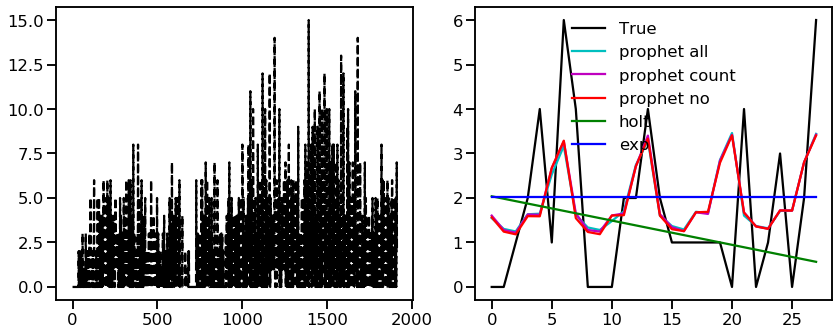

In [16]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
ax = ax.flatten()

# train data
ax[0].plot(np.arange(len(dates)), dates['y'].values, 'k--')

# predictions
ax[1].plot(np.arange(28), dates_eval['y'].iloc[-28:], 'k', label='True')
ax[1].plot(np.arange(28), pred_all, 'c', label='prophet all')
ax[1].plot(np.arange(28), pred_cout, 'm', label='prophet count')
ax[1].plot(np.arange(28), pred_no, 'r', label='prophet no')
ax[1].plot(np.arange(28), pred_holt, 'g', label='holt')
ax[1].plot(np.arange(28), pred_exp, 'b', label='exp')
ax[1].legend(frameon=False)
fig.tight_layout()

# Fitting

In [41]:
START_DATE = '2014-04-20' # almost 2 years ago
ids = df_sale['id'].values
print("Total IDs: {}".format(len(ids)))

Total IDs: 30490


In [42]:
def run_prophet_pool(id):
    ts = CreateTimeSeries(df_sale, id, start_date=START_DATE)
    pred = run_prophet(ts)
    return pred 

print(f'Parallelism on {cpu_count()} CPU')
with Pool(3) as p:
    predictions2  = list(p.map(run_prophet_pool, ids[:10]))

Parallelism on 4 CPU


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [46]:
predictions2

[array([ 6.06313656e-01,  7.30854871e-01,  5.39126527e-01,  4.23052681e-01,
         5.70150223e-01,  6.89357988e-01,  3.68808155e-01,  3.93098650e-01,
         5.00955307e-01,  4.08804978e-01, -3.17110857e-04,  3.50160974e-01,
         7.48446375e-01,  2.03038540e-01,  2.65471665e-01,  4.92688117e-01,
         2.19031228e-01,  1.09517612e-01,  3.39132386e-01,  6.09984826e-01,
         3.04418277e-01,  2.87948853e-01,  4.24573894e-01,  2.45564647e-01,
         1.42965888e-01,  3.04420949e-01,  6.39226387e-01,  3.63135696e-01]),
 array([0.09039485, 0.13062986, 0.17267072, 0.25061206, 0.27769094,
        0.33809277, 0.32840453, 0.16717072, 0.24682265, 0.29068399,
        0.40471038, 0.40920252, 0.46923429, 0.41510041, 0.3342216 ,
        0.37098486, 0.43377039, 0.50528301, 0.54645992, 0.511989  ,
        0.50149073, 0.39357083, 0.41878889, 0.44174762, 0.49693621,
        0.49808639, 0.50455275, 0.45162816]),
 array([0.56985791, 0.58766352, 0.56762065, 0.57337898, 0.63468368,
        0.84

In [51]:
df_sale.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [55]:
df_sale.loc[df_sale['id'] == ids[0], 'dept_id'].iloc[0]

'HOBBIES_1'

In [56]:
def make_sub(ids, predictions):
    df_prophet_forecast = pd.DataFrame()
    for k in range(0, len(predictions)):
        dept_id = df_sale.loc[df_sale['id'] == ids[k], 'dept_id'].iloc[0]
        store_id = df_sale.loc[df_sale['id'] == ids[k], 'store_id'].iloc[0]

        df_item = df_sale.loc[(df_sale.dept_id == dept_id) & (df_sale.store_id == store_id)][['id']]
        df_item['val'] = df_sale[(df_sale.dept_id == dept_id) & (df_sale.store_id == store_id)].iloc[:, np.r_[0,-28:0]].sum(axis = 1)
        for i in range(28):
            df_item[f'F{i+1}'] = (df_item['val'] * float(predictions[k][i]) / df_item['val'].sum())
        df_prophet_forecast = pd.concat([df_prophet_forecast, df_item])
    df_prophet_forecast = df_prophet_forecast.drop('val', axis=1)
    return df_prophet_forecast

df_prophet_forecast = make_sub(ids[:10], predictions2)
print(df_prophet_forecast.shape)
df_prophet_forecast.head()

(4160, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.001170,0.001410,0.001040,0.000816,0.001100,0.001330,0.000712,0.000759,0.000967,...,0.000654,0.001177,0.000587,0.000556,0.000819,0.000474,0.000276,0.000587,0.001233,0.000701
1,HOBBIES_1_002_CA_1_validation,0.000087,0.000104,0.000077,0.000060,0.000081,0.000099,0.000053,0.000056,0.000072,...,0.000048,0.000087,0.000044,0.000041,0.000061,0.000035,0.000020,0.000044,0.000091,0.000052
2,HOBBIES_1_003_CA_1_validation,0.000693,0.000836,0.000616,0.000484,0.000652,0.000788,0.000422,0.000450,0.000573,...,0.000388,0.000698,0.000348,0.000329,0.000486,0.000281,0.000163,0.000348,0.000731,0.000415
3,HOBBIES_1_004_CA_1_validation,0.002210,0.002664,0.001965,0.001542,0.002078,0.002513,0.001344,0.001433,0.001826,...,0.001236,0.002223,0.001110,0.001050,0.001548,0.000895,0.000521,0.001110,0.002330,0.001324
4,HOBBIES_1_005_CA_1_validation,0.001647,0.001985,0.001464,0.001149,0.001548,0.001872,0.001002,0.001068,0.001361,...,0.000921,0.001657,0.000827,0.000782,0.001153,0.000667,0.000388,0.000827,0.001736,0.000986
